# EXEMPLO - Aula_19: Algoritmos de Classificação: Regressão logística

Base de Dados <br>
Fonte da dados: kaglgle <br>
Link: https://www.kaggle.com/kost13/us-income-logistic-regression/data <br>
Resumo: Dados do Censo Adulto Americano referentes a renda para fatores sociais como Idade, Educação, raça, etc. <br>
Objetivo: Ajustar um modelo de regressão logística, em uma base de treinamento, para uma resposta binária, fazer a previsão desta resposta e avaliar a qualidade de ajuste do modelo em uma base de teste.


## Importando os Dados

In [325]:
from os import path
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

train = pd.read_csv(path.join('..', 'data', 'adult-training.csv'), names=columns)
test  = pd.read_csv(path.join('..', 'data', 'adult-test.csv'), names=columns, skiprows=1)

    
%matplotlib inline

In [326]:
train.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [327]:
train.shape

(32561, 15)

Mais informação sobre este data set pode se encontrada em: [archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

In [328]:
train.dtypes

Age                int64
Workclass         object
fnlgwt             int64
Education         object
Education num      int64
Marital Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital Gain       int64
Capital Loss       int64
Hours/Week         int64
Native country    object
Income            object
dtype: object

In [330]:
train.replace(' ?', np.nan, inplace=True)
test.replace(' ?', np.nan, inplace=True)

In [331]:
# verificando quantidade de missing para cada var
train.isnull().sum()

Age                  0
Workclass         1836
fnlgwt               0
Education            0
Education num        0
Marital Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours/Week           0
Native country     583
Income               0
dtype: int64

Como visto, somente Workclass, Occupation e Native country tem valores missing

# Parte_1A: Analisando as Variáveis Input - Missing/Categóricas

## Criando a variavel resposta binária a partir da variável Income

Transformando a variável Income-Renda em 0's and 1's

In [332]:
# apply: aplica uma fç a coluna especificada - no caso Income
# defini a fç lambda (nome de variável restrita do python) e já aplica ela
train['Income'] = train['Income'].apply(lambda x: 1 if x==' >50K' else 0)
test['Income'] = test['Income'].apply(lambda x: 1 if x==' >50K.' else 0)

## Workclass

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [333]:
train['Workclass'].fillna(' 0', inplace=True)
test['Workclass'].fillna(' 0', inplace=True)

In [335]:
train['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 0                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

As categorias Never-worked e Without-pay tem poucas obs então vamos juntá-las

In [336]:
train['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)
test['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)

## Education

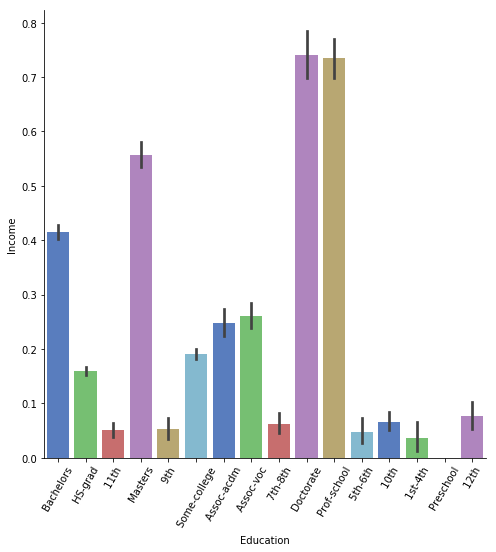

In [337]:
sns.factorplot(x="Education",y="Income",data=train,kind="bar", size = 7, 
palette = "muted")
plt.xticks(rotation=60);

A educação primária é dividada em grades:' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th'. <br>
Por isso vamos juntar essas classes em uma nova classe - Primary

In [338]:
def primary(x):
    if x in [' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th']:
        return ' Primary'
    else:
        return x

In [339]:
train['Education'] = train['Education'].apply(primary)
test['Education'] = test['Education'].apply(primary)

## Native country 

Tem algumas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [340]:
train['Native country'].fillna(' 0', inplace=True)
test['Native country'].fillna(' 0', inplace=True)

Vamos agrupar algumas categorias.

In [342]:
def native(country):
    if country in [' United-States', ' Cuba', ' 0']:
        return 'US'
    elif country in [' England', ' Germany', ' Canada', ' Italy', ' France', ' Greece', ' Philippines']:
        return 'Western'
    elif country in [' Mexico', ' Puerto-Rico', ' Honduras', ' Jamaica', ' Columbia', ' Laos', ' Portugal', ' Haiti',
                     ' Dominican-Republic', ' El-Salvador', ' Guatemala', ' Peru', 
                     ' Trinadad&Tobago', ' Outlying-US(Guam-USVI-etc)', ' Nicaragua', ' Vietnam', ' Holand-Netherlands' ]:
        return 'Poor' 
    elif country in [' India', ' Iran', ' Cambodia', ' Taiwan', ' Japan', ' Yugoslavia', ' China', ' Hong']:
        return 'Eastern'
    elif country in [' South', ' Poland', ' Ireland', ' Hungary', ' Scotland', ' Thailand', ' Ecuador']:
        return 'Poland team'
    
    else: 
        return country    

In [343]:
train['Native country'] = train['Native country'].apply(native)
test['Native country'] = test['Native country'].apply(native)

In [344]:
train['Native country'].value_counts()

US             29848
Poor            1415
Western          677
Eastern          386
Poland team      235
Name: Native country, dtype: int64

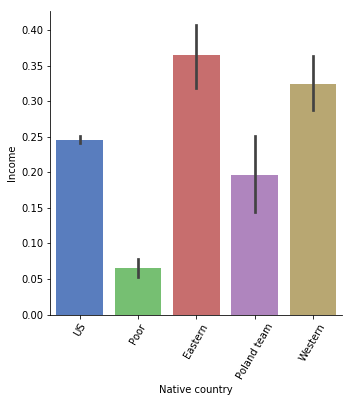

In [346]:
sns.factorplot(x="Native country",y="Income",data=train,kind="bar", size = 5, 
palette = "muted")
plt.xticks(rotation=60);

## Parte_1B: Criando Dummys

Agora precisamos criar dummys para as variáveis categóricas usando o pd.get_dummies(). <br>
Como esse método pode causar alguns problemas, mesclarmos os conjuntos de dados. Isso garante que as dimensões para ambos os conjuntos de dados sejam iguais às dos conjuntos de dados de treinamento e teste.

In [347]:
#merge datasets
joint = pd.concat([train, test], axis=0)
# Renaming certain columns for better readability
joint = joint.rename(columns={'Education num': 'Education_num', 
                        'Marital Status': 'Marital',
                        'Capital Gain': 'Capital_Gain',
                        'Capital Loss': 'Capital_Loss',
                        'Hours/Week': 'Hours_Week',
                        'Native country': 'Country'
                                                })

In [302]:
#joint.dtypes

In [348]:
#list of columns with dtype: object
#axes[1] coluna
#axes[0] linha
categorical_features = joint.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, joint[col].nunique()) # retorna as vars que são do tipo objeto e a quantidade de categorias em cada uma delas

Workclass 8
Education 10
Marital 7
Occupation 14
Relationship 6
Race 5
Sex 2
Country 5


In [349]:
#criando dummys para as variáveis categoricas
for col in categorical_features:
    joint = pd.concat([joint, pd.get_dummies(joint[col], prefix=col, prefix_sep='_')], axis=1)
    joint.drop(col, axis=1, inplace=True)

In [350]:
# renomeando as variáveis
new_columns = {}
for i in joint.columns:
    new_column = i.replace(" ", "")
    new_column = new_column.replace("-", "_")
    new_columns[i] = new_column

joint = joint.rename(columns=new_columns)

In [306]:
#joint.columns

In [351]:
joint.head()

,Age,fnlgwt,Education_num,Capital_Gain,Capital_Loss,Hours_Week,Income,Workclass_0,Workclass_Federal_gov,Workclass_Local_gov,Workclass_Never_worked,Workclass_Private,Workclass_Self_emp_inc,Workclass_Self_emp_not_inc,Workclass_State_gov,Education_Assoc_acdm,Education_Assoc_voc,Education_Bachelors,Education_Doctorate,Education_HS_grad,Education_Masters,Education_Preschool,Education_Primary,Education_Prof_school,Education_Some_college,Marital_Divorced,Marital_Married_AF_spouse,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Occupation_Adm_clerical,Occupation_Armed_Forces,Occupation_Craft_repair,Occupation_Exec_managerial,Occupation_Farming_fishing,Occupation_Handlers_cleaners,Occupation_Machine_op_inspct,Occupation_Other_service,Occupation_Priv_house_serv,Occupation_Prof_specialty,Occupation_Protective_serv,Occupation_Sales,Occupation_Tech_support,Occupation_Transport_moving,Relationship_Husband,Relationship_Not_in_family,Relationship_Other_relative,Relationship_Own_child,Relationship_Unmarried,Relationship_Wife,Race_Amer_Indian_Eskimo,Race_Asian_Pac_Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,Country_Eastern,Country_Polandteam,Country_Poor,Country_US,Country_Western
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Separando novamente a base em treinamento e teste.

In [352]:
train = joint.head(train.shape[0])
test = joint.tail(test.shape[0])

Dividindo o data frame em inputs e target

In [353]:
Xtrain = train.drop('Income', axis=1)
Ttrain = train['Income']

Xtest = test.drop('Income', axis=1)
Ttest = test['Income']

#scaler = StandardScaler()
#scaler.fit(Xtrain)
#Xtrain = scaler.transform(Xtrain)
#Xtest = scaler.transform(Xtest)

In [354]:
Xtrain.head()

,Age,fnlgwt,Education_num,Capital_Gain,Capital_Loss,Hours_Week,Workclass_0,Workclass_Federal_gov,Workclass_Local_gov,Workclass_Never_worked,Workclass_Private,Workclass_Self_emp_inc,Workclass_Self_emp_not_inc,Workclass_State_gov,Education_Assoc_acdm,Education_Assoc_voc,Education_Bachelors,Education_Doctorate,Education_HS_grad,Education_Masters,Education_Preschool,Education_Primary,Education_Prof_school,Education_Some_college,Marital_Divorced,Marital_Married_AF_spouse,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Occupation_Adm_clerical,Occupation_Armed_Forces,Occupation_Craft_repair,Occupation_Exec_managerial,Occupation_Farming_fishing,Occupation_Handlers_cleaners,Occupation_Machine_op_inspct,Occupation_Other_service,Occupation_Priv_house_serv,Occupation_Prof_specialty,Occupation_Protective_serv,Occupation_Sales,Occupation_Tech_support,Occupation_Transport_moving,Relationship_Husband,Relationship_Not_in_family,Relationship_Other_relative,Relationship_Own_child,Relationship_Unmarried,Relationship_Wife,Race_Amer_Indian_Eskimo,Race_Asian_Pac_Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,Country_Eastern,Country_Polandteam,Country_Poor,Country_US,Country_Western
0,39,77516,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Parte_1C: Verificando a correlação entre as variáveis Dummy para cada var_original

,Marital_Divorced,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Income
Marital_Divorced,1.000000,-0.366837,-0.045331,-0.277772,-0.071665,-0.070501,-0.126995
Marital_Married_civ_spouse,-0.366837,1.000000,-0.105238,-0.644866,-0.166374,-0.163673,0.444696
Marital_Married_spouse_absent,-0.045331,-0.105238,1.000000,-0.079687,-0.020559,-0.020225,-0.042532
Marital_Never_married,-0.277772,-0.644866,-0.079687,1.000000,-0.125980,-0.123935,-0.318440
Marital_Separated,-0.071665,-0.166374,-0.020559,-0.125980,1.000000,-0.031975,-0.074386
Marital_Widowed,-0.070501,-0.163673,-0.020225,-0.123935,-0.031975,1.000000,-0.064381
Income,-0.126995,0.444696,-0.042532,-0.318440,-0.074386,-0.064381,1.000000


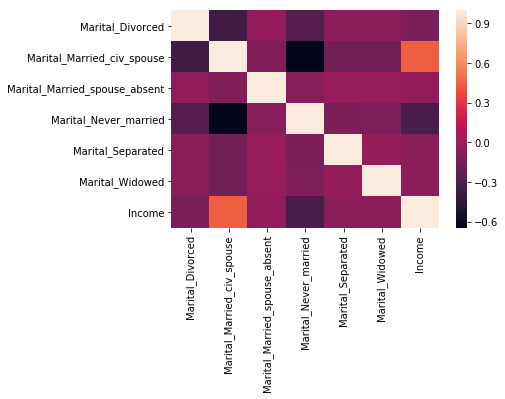

In [355]:
# matriz de correlação das variáveis Marital
Base_Marital = train[['Marital_Divorced', 'Marital_Married_civ_spouse', 'Marital_Married_spouse_absent',
 'Marital_Never_married', 'Marital_Separated', 'Marital_Widowed','Income']]
corr = Base_Marital.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
corr
# Variáveis mais corr com a resposta Income: 'Marital_Married_civ_spouse', 'Marital_Divorced',

Variáveis a serem utilizadas no método forward para seleção
    'Workclass_Self_emp_inc', 'Workclass_Private', 'Workclass_0',
    'Education_Bachelors', 'Education_Masters', 'Education_Primary','Education_Prof_school',
    'Marital_Married_civ_spouse', 'Marital_Divorced',
    'Occupation_Exec_managerial', 'Occupation_Other_service','Occupation_Prof_specialty',
    'Relationship_Husband', 'Relationship_Own_child',
    'Race_White',
    'Sex_Female',
    'CountryPoor','CountryUS'

## Parte_2: Metodo de seleção de variáveis forward

In [356]:
#Metodo de seleção de variáveis forward usando statsmodels
import statsmodels.formula.api as smf
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [357]:
train_1 = train[[
    'Workclass_Self_emp_inc', 'Workclass_Private', 'Workclass_0',
    'Education_Bachelors', 'Education_Masters', 'Education_Primary','Education_Prof_school',
    'Marital_Married_civ_spouse', 'Marital_Divorced',
    'Occupation_Exec_managerial', 'Occupation_Other_service','Occupation_Prof_specialty',
    'Relationship_Husband', 'Relationship_Own_child',
    'Race_White',
    'Sex_Female',
    'Country_Poor','Country_US',
    'Age','fnlgwt','Education_num','Capital_Gain','Capital_Loss','Hours_Week',
    'Income',
]]

In [358]:
#colocar para rodar quando for sair para o almoço
#aplicando o método de seleção de variáveis forward

model = forward_selected(train_1, 'Income')

print(model.model.formula)
print(model.rsquared_adj)


Income ~ Marital_Married_civ_spouse + Education_num + Capital_Gain + Occupation_Exec_managerial + Capital_Loss + Hours_Week + Age + Occupation_Prof_specialty + Education_Primary + Workclass_Self_emp_inc + Workclass_Private + Sex_Female + Relationship_Husband + fnlgwt + Race_White + Education_Masters + Country_Poor + Education_Prof_school + Occupation_Other_service + Education_Bachelors + Relationship_Own_child + 1
0.354320492058


## Parte_3: Ajustando e Escorado um modelo de Regressão Logística usando sklearn

In [359]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import pylab as pl



In [360]:
# Utilizando as vars selecionadas pelo método forward
iv = ['Marital_Married_civ_spouse','Education_num','Capital_Gain','Occupation_Exec_managerial','Capital_Loss','Hours_Week',
'Age','Occupation_Prof_specialty','Education_Primary','Workclass_Self_emp_inc','Workclass_Private','Sex_Female',
'Relationship_Husband','fnlgwt','Race_White','Education_Masters','Country_Poor','Education_Prof_school',
'Occupation_Other_service','Education_Bachelors','Relationship_Own_child']


In [361]:
model = LogisticRegression()
a = model.fit(Xtrain[iv], Ttrain)

model.fit(Xtrain[iv], Ttrain)
Ytrain = model.predict(Xtrain[iv])
Ytest = model.predict(Xtest[iv])

#testess = model.predict_proba(Xtest_1)

In [362]:
a.coef_

array([[  3.71160725e-03,  -2.33375845e-03,   3.37194647e-04,
          1.12511794e-03,   7.77102583e-04,  -1.01525382e-02,
         -4.87717924e-03,   8.94197038e-04,  -1.27469198e-03,
          3.77019356e-04,  -1.87317422e-03,  -2.72804766e-03,
          3.33849467e-03,  -3.69920593e-06,  -9.97362043e-04,
          6.22204857e-04,  -3.32428535e-04,   2.90869571e-04,
         -1.12132941e-03,   9.86345986e-04,  -2.01858305e-03]])

In [363]:
# Calculando confusion matrix, AUC, precision e recall para base de treinamento
#model.fit(Xtrain, Ttrain)
cnf_matrix = confusion_matrix(Ttrain, Ytrain)
print ("\n\n ---Base de Treinamento---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)

print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(Ttrain, model.predict(Xtrain[iv]))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(Ttrain, Ytrain))



 ---Base de Treinamento---


 ---Matriz de Confusão---
[[23918   802]
 [ 5780  2061]]


 ---Logistic Model---
Logistic AUC = 0.62
             precision    recall  f1-score   support

          0       0.81      0.97      0.88     24720
          1       0.72      0.26      0.39      7841

avg / total       0.78      0.80      0.76     32561



In [365]:
# Calculando AUC, precision e recall para base de teste
#model.fit(Xtest, Ttest)
cnf_matrix = confusion_matrix(Ttest, Ytest)
print ("\n\n ---Base de Teste---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(Ttest, model.predict(Xtest[iv]))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(Ttest, Ytest))



 ---Base de Teste---


 ---Matriz de Confusão---
[[12021   414]
 [ 2848   998]]


 ---Logistic Model---
Logistic AUC = 0.61
             precision    recall  f1-score   support

          0       0.81      0.97      0.88     12435
          1       0.71      0.26      0.38      3846

avg / total       0.78      0.80      0.76     16281



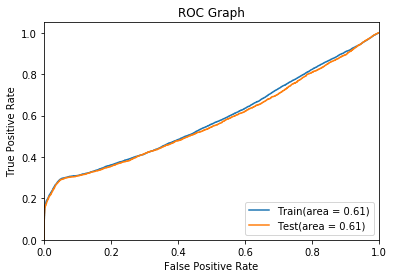

In [366]:
# Plotando o curva ROC para a base de treinamento
fpr, tpr, thresholds = roc_curve(Ttrain, model.predict_proba(Xtrain[iv])[:,1])
# fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Train(area = %0.2f)' % logit_roc_auc)

# Plotando o curva ROC para a base de teste
fpr, tpr, thresholds = roc_curve(Ttest, model.predict_proba(Xtest[iv])[:,1])
plt.plot(fpr, tpr, label='Test(area = %0.2f)' % logit_roc_auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## Parte_4: Ajustando e Escorado um modelo de Regressão Logística usando statsmodels

In [367]:
# Modelo com variáveis obtidas do método forward
iv = ['Marital_Married_civ_spouse','Education_num','Capital_Gain','Occupation_Exec_managerial','Capital_Loss','Hours_Week',
'Age','Occupation_Prof_specialty','Education_Primary','Workclass_Self_emp_inc','Workclass_Private','Sex_Female',
'Relationship_Husband','fnlgwt','Race_White','Education_Masters','Country_Poor','Education_Prof_school',
'Occupation_Other_service','Education_Bachelors','Relationship_Own_child']

logReg = sm.Logit(Ttrain, Xtrain[iv])

#Ytrain = logReg.predict(Xtrain[iv])
#Ytest = logReg.predict(Xtest)
answer = logReg.fit()

answer.summary2()


Optimization terminated successfully.
         Current function value: 0.353664
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit               Pseudo R-squared:    0.359     
Dependent Variable:     Income              AIC:                 23073.3356
Date:                   2018-04-04 19:38    BIC:                 23249.5439
No. Observations:       32561               Log-Likelihood:      -11516.   
Df Model:               20                  LL-Null:             -17974.   
Df Residuals:           32540               LLR p-value:         0.0000    
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         9.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Marital_Married_civ_spouse  2.6771   0.0757  35.3666 0.0000  2.5287  2.8254
Education_num              -0.2224   0.0096 -23.1670 0.0000 -0.2413 -0.2036
Capital_Gain                0.0003   0.0000  31.8738 0.0000  0.0003  0.0003
Occupation_Exec_managerial  0.9131   0.0470  19.4283 0.0000  0.8210  1.0052
Capital_Loss                0.0007   0.0000  19.0496 0.0000  0.0006  0.0007
Hours_Week                  0.0050   0.0014   3.6265 0.0003  0.0023  0.0076
Age                         0.0011   0.0013   0.8152 0.4150 -0.0015  0.0037
Occupation_Prof_specialty   0.8646   0.0529  16.3424 0.0000  0.7609  0.9683
Education_Primary          -2.2263   0.0876 -25.4237 0.0000 -2.3979 -2.0546
Workclass_Self_emp_inc      0.4802   0.0834   5.7604 0.0000  0.3168  0.6435
Workclass_Private          -0.0883   0.0364  -2.4262 0.0153 -0.1597 -0.0170
Sex_Female                 -1.0682   0.0654 -16.3203 0.0000 -1.1964 -0.9399
Relationship_Husband       -1.0980   0.0866 -12.6799 0.0000 -1.2678 -0.9283
fnlgwt                     -0.0000   0.0000  -4.2022 0.0000 -0.0000 -0.0000
Race_White                 -0.3535   0.0497  -7.1152 0.0000 -0.4509 -0.2561
Education_Masters           1.8663   0.0791  23.5843 0.0000  1.7112  2.0214
Country_Poor               -1.2604   0.1277  -9.8700 0.0000 -1.5107 -1.0101
Education_Prof_school       2.4680   0.1329  18.5670 0.0000  2.2075  2.7285
Occupation_Other_service   -1.0943   0.0993 -11.0204 0.0000 -1.2889 -0.8996
Education_Bachelors         1.3656   0.0541  25.2343 0.0000  1.2595  1.4717
Relationship_Own_child     -2.1086   0.1400 -15.0638 0.0000 -2.3829 -1.8342
===========================================================================

"""

In [368]:
# Calculando o valor predito das bases de treinamento e validação
Ytrain = answer.predict(Xtrain[iv])

fpr1, tpr1, thresholds =roc_curve(Ttrain, Ytrain)
roc_auc1 = auc(fpr1, tpr1)
print("Area under the ROC curve Train : %f" % roc_auc1)

Ytest = answer.predict(Xtest[iv])

fpr2, tpr2, thresholds =roc_curve(Ttest, Ytest)
roc_auc2 = auc(fpr2, tpr2)
print("Area under the ROC curve Test : %f" % roc_auc2)

Area under the ROC curve Train : 0.878363
Area under the ROC curve Test : 0.879705


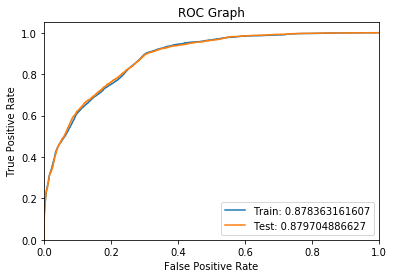

In [369]:
# plotando a curva ROC para as bases de treinamento e validação
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(["Train: " + str(roc_auc1), "Test: " + str(roc_auc2)  ],  loc="lower right")
plt.show()

Referências <br>
- https://www.kaggle.com/kost13/us-income-logistic-regression
- http://planspace.org/20150423-forward_selection_with_statsmodels/